# Tema 3 IA - Sumarizarea documentelor
- Roxana-Elena Stiuca, 343C4

## Setup
Bibloteci necesare:
- spacy + python -m spacy download en_core_web_sm

In [215]:
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !pip install matplotlib

import zipfile
import matplotlib.pyplot as plt
from spacy import load as spacy_load
from random import shuffle
from collections import Counter, defaultdict, namedtuple
from math import log
from itertools import chain

## Cerinta 1
### Setul de date
Incarcam in memorie setul de date BBC News Summaries (e nevoie de arhiva news.zip in directorul curent).

In [164]:
BUSINESS, ENTERTAINMENT, POLITICS, SPORT, TECH = list(range(5))
CATEGORIES = ['business', 'entertainment', 'politics', 'sport', 'tech']

news = []
summaries = []
zipFile = zipfile.ZipFile("news.zip")

for idx_category in range(len(CATEGORIES)):
    news.append([f for f in zipFile.namelist() if 'bbc news summary/BBC News Summary/News Articles/' + CATEGORIES[idx_category] in f])
    news[idx_category].sort()
    summaries.append([f for f in zipFile.namelist() if 'bbc news summary/BBC News Summary/Summaries/' + CATEGORIES[idx_category] in f])
    summaries[idx_category].sort()
    
# Test:
print(len(news[POLITICS]))

417


### Tokenizare, eliminarea cuvintelor neinformative si lematizare
Aplicam tokenizarea asupra fisierelor. Sunt impartite pe propozitii, iar fiecare propozitie este impartita la randul sau in tokens. Prin parametrii functiei putem controla daca dorim ca tokens sa fie cuvinte, bigrame sau 4-grame, daca se vor elimina cuvintele neinformative si daca se aplica lematizarea.

In [165]:
nlp = spacy_load("en_core_web_sm")
nlp.add_pipe('sentencizer')

def get_tokens(sent, elim_stop=True, lemma=True):
    words = []
    for word in sent:
        if word.is_space or word.is_punct:
            continue
        if elim_stop and word.is_stop:
            continue
        if lemma:
            words.append(word.lemma_)
        else:
            words.append(word.text)
    return words

def make_ngrams(words, ngram):
    if len(words) == 0:
        return []
    if ngram == 1:
        return words
    elif ngram == 2:
        # make bigrams
        bigrams = []
        first_word = words[0]
        for second_word in words[1:]:
            bigrams.append(first_word + ":" + second_word)
            first_word = second_word
        return bigrams
    elif ngram == 4:
        # make 4-grams
        ngrams = []
        for i in range(len(words) - 3):
            ngrams.append(words[i] + ":" + words[i+1] + ":" + words[i+2] + ":" + words[i+3])
        return ngrams
            
def process_file(filepath, ngram=1, elim_stop=True, lemma=True):
    """
    Yield one sentence at a time as a tuple (original text, array of tokens/ngrams).
    """
    with zipFile.open(filepath) as f:
        for line in f.readlines():
            if len(line) <= 1:
                continue
            text = line.decode("utf-8", "ignore")
            doc = nlp(text)
            for sent in doc.sents:
                words = get_tokens(sent, elim_stop, lemma)
                ngrams = make_ngrams(words, ngram)
                if len(ngrams) > 0:
                    yield sent.text, ngrams

## Cerinta 2 - Naive Bayes

### Impartirea datelor in cele de antrenare si cele de test

In [166]:
news_train = []
summaries_train = []
news_test = []
summaries_test = []

for idx in range(len(CATEGORIES)):
    data = list(zip(news[idx], summaries[idx]))
    shuffle(data)
    news[idx], summaries[idx] = zip(*data)
    
    train_no = int(.75 * len(news[idx]))
    news_train.append(news[idx][:train_no])
    summaries_train.append(summaries[idx][:train_no])
    news_test.append(news[idx][train_no:])
    summaries_test.append(summaries[idx][train_no:])
    
# Test:
print(len(news_train[POLITICS]), " ", len(summaries_train[POLITICS]))

312   312


### Antrenare
Construim vocabularul si calculam parametrii necesari predictiei.

In [167]:
def count_words(news, summaries, ngrams=1, elim_stop=True, lemma=True):
    """
    Returns:
    - dictionary {word: number of apparitions of word in summaries},
    - dictionary {word: number of apparitions of word in news, but not in summary},
    - total number of words in summaries,
    - total number of words which appear in text, but not in summary,
    - total number of sentences in news,
    - total number of sentences in summaries
    """
    words_in_summaries = 0
    freq_words_summaries = Counter()
    sent_in_summaries = 0
    
    for summary in summaries:
        for sent, words in process_file(summary, ngrams, elim_stop, lemma):
            sent_in_summaries += 1
            words_in_summaries += len(words)
            freq_words_summaries += Counter(words)
    
    words_no = 0
    freq_words = Counter()
    sent_no = 0
    
    for doc in news:
        for sent, words in process_file(doc, ngrams, elim_stop, lemma):
            sent_no += 1
            words_no += len(words)
            freq_words += Counter(words)
            
    words_not_in_summaries = words_no - words_in_summaries
    freq_words_not = Counter()
    
    for word in freq_words.keys():
        freq_words_not[word] = max(0, freq_words[word] - freq_words_summaries[word])

    return (
        words_in_summaries, freq_words_summaries, sent_in_summaries,
        words_not_in_summaries, freq_words_not, sent_no
    )

### Sumarizarea unui text pe baza parametrilor calculati

In [168]:
def summarize_bayes(params, filepath, ngrams=1, elim_stop=True, lemma=True, alpha=1):
    """
    Return summarization for file, given model's parameters.
    Also, return a processed summarization (where the text is divided into sentences
    and tokens) which makes evaluation more efficient.
    """
    (words_in, freq_in, sent_in, words_not, freq_not, sent_total) = params
    summary = []
    processed_summary = []
    log_Pc = log(float(sent_in) / float(sent_total))
    voc_len = len(set(freq_in.keys()) | set(freq_not.keys()))
    
    for orig_sent, sent in process_file(filepath, ngrams, elim_stop, lemma):
        # Decide if sent should be in summary or not.
        log_in = log_Pc
        log_not = log_Pc
        
        for word in sent:
            aux1 = freq_in.get(word, 0)
            aux2 = freq_not.get(word, 0)
            
            log_in += log((aux1 + alpha) / (words_in + alpha * voc_len))
            log_not += log((aux2 + alpha) / (words_not + alpha * voc_len))
        
        if log_in > log_not:
            summary.append(orig_sent)
            processed_summary.append(sent)
    
    return ("".join(summary), processed_summary)

### Evaluarea performantelor

In [270]:
def evaluate(params, summarize_func, ngrams=1, elim_stop=True, lemma=True, categories=[0,1,2,3,4]):
    scores = []
    
    for idx in range(len(CATEGORIES)):
        if idx not in categories:
            continue

        common_no = 0    # nb. of common n-grams
        predicted_no = 0 # nb. of n-grams in predicted summary
        actual_no = 0    # nb. of n-grams in actual summary
        
        for news, summary in zip(news_test[idx], summaries_test[idx]):
            _, summary_sentences = zip(*list(process_file(summary, ngrams, elim_stop, lemma)))
            _, predicted_summary_sentences = summarize_func(params[idx], news, ngrams, elim_stop, lemma)
            
            freq_actual = Counter(chain(*summary_sentences))
            freq_predicted = Counter(chain(*predicted_summary_sentences))
            
            for ngram in (set(freq_actual.keys()) | set(freq_predicted.keys())):
                aux1 = freq_actual.get(ngram, 0)
                aux2 = freq_predicted.get(ngram, 0)
                common_no += min(aux1, aux2)
                predicted_no += aux1
                actual_no += aux2
        
        blue = common_no / predicted_no
        rouge = common_no / actual_no
        scores.append((blue, rouge))
    
    if len(categories) > 1:
        # Compute weighted average for scores
        docs_no = sum(len(news_test[i]) for i in range(len(CATEGORIES)))
        blue = sum([scores[i][0] * len(news_test[i]) for i in range(len(CATEGORIES))]) / docs_no
        rouge = sum([scores[i][1] * len(news_test[i]) for i in range(len(CATEGORIES))]) / docs_no
    else:
        blue = scores[0][0]
        rouge = scores[0][1]
    
    return (round(blue, 2), round(rouge, 2))

## Cerinta 2 - Rezultate pentru Naive Bayes

In [170]:
def train_and_evaluate_bayes(ngrams, elim_stop, lemma):
    training_results = []
    for idx in range(len(CATEGORIES)):
        training_results.append(count_words(news_train[idx], summaries_train[idx], ngrams, elim_stop, lemma))
    
    return evaluate(training_results, summarize_bayes, ngrams, elim_stop, lemma)

Result = namedtuple("Result", ["model", "blue", "rouge"])
results = []

### Evaluare unigrame

In [171]:
results.append(Result("NB pentru unigrame", *train_and_evaluate_bayes(1, False, False)))
results.append(Result("NB pentru unigrame, fara stop words", *train_and_evaluate_bayes(1, True, False)))
results.append(Result("NB pentru unigrame, fara stop words, cu lematizare", *train_and_evaluate_bayes(1, True, True)))

### Evaluare bigrame

In [172]:
results.append(Result("NB pentru bigrame", *train_and_evaluate_bayes(2, False, False)))
results.append(Result("NB pentru bigrame, fara stop words", *train_and_evaluate_bayes(2, True, False)))
results.append(Result("NB pentru bigrame, fara stop words, cu lematizare", *train_and_evaluate_bayes(2, True, True)))

### Evaluare 4-grame

In [173]:
results.append(Result("NB pentru 4grame", *train_and_evaluate_bayes(4, False, False)))
results.append(Result("NB pentru 4grame, fara stop words", *train_and_evaluate_bayes(4, True, False)))
results.append(Result("NB pentru 4grame, fara stop words, cu lematizare", *train_and_evaluate_bayes(4, True, True)))

In [174]:
for r in results:
    print(r)

Result(model='NB pentru unigrame', blue=0.62, rouge=0.66)
Result(model='NB pentru unigrame, fara stop words', blue=0.59, rouge=0.6)
Result(model='NB pentru unigrame, fara stop words, cu lematizare', blue=0.57, rouge=0.62)
Result(model='NB pentru bigrame', blue=0.69, rouge=0.55)
Result(model='NB pentru bigrame, fara stop words', blue=0.74, rouge=0.51)
Result(model='NB pentru bigrame, fara stop words, cu lematizare', blue=0.72, rouge=0.51)
Result(model='NB pentru 4grame', blue=0.89, rouge=0.48)
Result(model='NB pentru 4grame, fara stop words', blue=0.74, rouge=0.55)
Result(model='NB pentru 4grame, fara stop words, cu lematizare', blue=0.74, rouge=0.55)


## Cerinta 3 - TF-IDF

In [175]:
def get_tokens_tfidf(sent, only_subst=True):
    words = []
    for word in sent:
        if word.is_space or word.is_punct or word.is_stop:
            continue
        if only_subst and word.tag_ not in ['NN', 'NNP', 'NNS']:
            continue
        words.append(word.lemma_)
    return words

def make_ngrams_tfidf(words, ngram):
    if len(words) == 0:
        return []
    if ngram == 1:
        return words
    elif ngram == 2:
        # make bigrams
        bigrams = []
        first_word = words[0]
        for second_word in words[1:]:
            bigrams.append(first_word + ":" + second_word)
            first_word = second_word
        return bigrams
    elif ngram == 4:
        # make 4-grams
        ngrams = []
        for i in range(len(words) - 3):
            ngrams.append(words[i] + ":" + words[i+1] + ":" + words[i+2] + ":" + words[i+3])
        return ngrams
            
def process_file_tfidf(filepath, ngram=1, only_subst=True):
    """
    Yield one sentence at a time as a tuple (original text, array of tokens/ngrams).
    """
    with zipFile.open(filepath) as f:
        for line in f.readlines():
            if len(line) <= 1:
                continue
            text = line.decode("utf-8", "ignore")
            doc = nlp(text)
            for sent in doc.sents:
                words = get_tokens_tfidf(sent, only_subst)
                ngrams = make_ngrams_tfidf(words, ngram)
                if len(ngrams) > 0:
                    yield sent.text, ngrams

### Antrenare
Construim vocabularul si calculam parametrii necesari predictiei (scorurile tfidf ale fiecarui token/ngram).

In [193]:
def compute_scores(news, ngrams=1, only_subst=True):
    """
    Returns:
    - dictionary {word: tfidf score}
    """
    tf = Counter() # dictionary {word: number of appartions in all documents}
    idf = defaultdict(int) # dictionary {word: number of documents it appears in}
    
    for doc in news:
        _, sent = zip(*list(process_file_tfidf(doc, ngrams, only_subst)))
        words = chain(*sent)
        tf += Counter(words)
        for word in tf.keys():
            idf[word] += 1
            
    tfidf = {}
    
    for word, tf_score in tf.items():
        tfidf[word] = tf_score * log(len(news) / idf[word])
        
    return tfidf

### Sumarizarea unui text pe baza parametrilor calculati

In [ ]:
def normalization(a):
    minimum = min(a)
    maximum = max(a)
    if minimum == maximum:
        minimum = 0
    if maximum == 0:
        return a
    return [(float(i)-minimum)/(maximum-minimum) for i in a]

# Weights for score computing:
param_title = 0.1
param_position = 0.1

def summarize_tfidf(
    scores, filepath,
    ngrams=1, only_subst=True, use_title=True, weight_position=True
):
    """
    Return summarization for file, given TFIDF scores for each word/ngram.
    Also, return a processed summarization (where the text is divided into sentences
    and tokens) which makes evaluation more efficient.
    """
    sent_scores = []
    title_scores = []
    position_scores = []
    
    sentences = list(process_file_tfidf(filepath, ngrams, only_subst))
    title = set(sentences[0][1])
    
    for idx, (orig_sent, sent) in enumerate(sentences):
        current_score = 0.0
        words_in_title = 0
        for word in sent:
            current_score += scores.get(word, 0.0)
            if use_title and word in title:
                words_in_title += 1
        
        sent_scores.append(current_score)
        title_scores.append(words_in_title / len(title))
        position_scores.append(idx / len(sentences))
        
    # Normalize score array
    sent_scores = normalization(sent_scores)
    
    # Add scores
    if use_title or weight_position:
        for idx in range(len(sent_scores)):
            if use_title:
                sent_scores[idx] += param_title * title_scores[idx]
            if weight_position:
                sent_scores[idx] += param_position * position_scores[idx]
        
    # Choose first k sentences (k = 30% of all sentences) / 20%/3
#     k = int(.3 * len(sentences))
    k = max(3, int(.2 * len(sentences)))
    
    aux = sent_scores.copy()
    aux.sort()
    kth_max_score = aux[-k] if len(aux) > k else aux[0]
#     if kth_max_score < 0.5: # folosirea unui scor minim
#         kth_max_score = 0.5
    
    summary = []
    processed_summary = []

    for idx in range(1, len(sentences)): # imbunatatire 2
#     for idx in range(len(sentences)):
        if sent_scores[idx] >= kth_max_score:
            summary.append(sentences[idx][0])
            processed_summary.append(sentences[idx][1])
            
    return ("".join(summary), processed_summary)

### Evaluarea performantelor

In [294]:
def evaluate_tfidf(
    params, summarize_func,
    ngrams=1, only_subst=True, use_title=True, weight_position=True,
    categories=[0,1,2,3,4]
):
    scores = []
    
    for idx in range(len(CATEGORIES)):
        if idx not in categories:
            continue
            
        common_no = 0    # nb. of common n-grams
        predicted_no = 0 # nb. of n-grams in predicted summary
        actual_no = 0    # nb. of n-grams in actual summary
        
        for news, summary in zip(news_test[idx], summaries_test[idx]):
            tmp, summary_sentences = zip(*list(process_file_tfidf(summary, ngrams, only_subst)))
            tmp2, predicted_summary_sentences = summarize_func(params[idx], news, ngrams, only_subst, use_title, weight_position)
            
            freq_actual = Counter(chain(*summary_sentences))
            freq_predicted = Counter(chain(*predicted_summary_sentences))
            
            for ngram in (set(freq_actual.keys()) | set(freq_predicted.keys())):
                aux_actual = freq_actual.get(ngram, 0)
                aux_predicted = freq_predicted.get(ngram, 0)

                common_no += min(aux_actual, aux_predicted)
                predicted_no += aux_predicted
                actual_no += aux_actual
                
        blue = common_no / predicted_no
        rouge = common_no / actual_no
        scores.append((blue, rouge))
    
    if len(categories) > 1:
        # Compute weighted average for scores
        docs_no = sum(len(news_test[i]) for i in range(len(CATEGORIES)))
        blue = sum([scores[i][0] * len(news_test[i]) for i in range(len(CATEGORIES))]) / docs_no
        rouge = sum([scores[i][1] * len(news_test[i]) for i in range(len(CATEGORIES))]) / docs_no
    else:
        blue = scores[0][0]
        rouge = scores[0][1]
    
    return (round(blue, 2), round(rouge, 2))

## Cerinta 3 - Rezultate pentru TF-IDF

In [259]:
def train_and_evaluate_tfidf(ngrams, only_subst, use_title, weight_position):
    training_results = []
    for idx in range(len(CATEGORIES)):
        training_results.append(compute_scores(news_train[idx], ngrams, only_subst))
    
    return evaluate_tfidf(training_results, summarize_tfidf, ngrams, only_subst, use_title, weight_position)

### Evaluare unigrame

In [197]:
results.append(Result("TF-IDF pentru unigrame", *train_and_evaluate_tfidf(1, False, False, False)))
results.append(Result("TF-IDF pentru unigrame, doar substantive", *train_and_evaluate_tfidf(1, True, False, False)))
results.append(Result("TF-IDF pentru unigrame, doar substantive, similaritate cu titlu",
                      *train_and_evaluate_tfidf(1, True, True, False)))
results.append(Result("TF-IDF pentru unigrame, doar substantive, similaritate cu titlu, pozitia in text",
                      *train_and_evaluate_tfidf(1, True, True, True)))

### Evaluare bigrame

In [199]:
results.append(Result("TF-IDF pentru bigrame", *train_and_evaluate_tfidf(2, False, False, False)))
results.append(Result("TF-IDF pentru bigrame, doar substantive", *train_and_evaluate_tfidf(2, True, False, False)))
results.append(Result("TF-IDF pentru bigrame, doar substantive, similaritate cu titlu",
                      *train_and_evaluate_tfidf(2, True, True, False)))
results.append(Result("TF-IDF pentru bigrame, doar substantive, similaritate cu titlu, pozitia in text",
                      *train_and_evaluate_tfidf(2, True, True, True)))

### Evaluare 4-grame

In [213]:
results.append(Result("TF-IDF pentru 4-grame", *train_and_evaluate_tfidf(4, False, False, False)))
results.append(Result("TF-IDF pentru 4-grame, doar substantive", *train_and_evaluate_tfidf(4, True, False, False)))
results.append(Result("TF-IDF pentru 4-grame, doar substantive, similaritate cu titlu",
                      *train_and_evaluate_tfidf(4, True, True, False)))
results.append(Result("TF-IDF pentru 4-grame, doar substantive, similaritate cu titlu, pozitia in text",
                      *train_and_evaluate_tfidf(4, True, True, True)))

In [214]:
for r in results:
    print(r)

Result(model='NB pentru unigrame', blue=0.62, rouge=0.66)
Result(model='NB pentru unigrame, fara stop words', blue=0.59, rouge=0.6)
Result(model='NB pentru unigrame, fara stop words, cu lematizare', blue=0.57, rouge=0.62)
Result(model='NB pentru bigrame', blue=0.69, rouge=0.55)
Result(model='NB pentru bigrame, fara stop words', blue=0.74, rouge=0.51)
Result(model='NB pentru bigrame, fara stop words, cu lematizare', blue=0.72, rouge=0.51)
Result(model='NB pentru 4grame', blue=0.89, rouge=0.48)
Result(model='NB pentru 4grame, fara stop words', blue=0.74, rouge=0.55)
Result(model='NB pentru 4grame, fara stop words, cu lematizare', blue=0.74, rouge=0.55)
Result(model='TF-IDF pentru unigrame', blue=0.58, rouge=0.65)
Result(model='TF-IDF pentru unigrame, doar substantive', blue=0.59, rouge=0.67)
Result(model='TF-IDF pentru unigrame, doar substantive, similaritate cu titlu', blue=0.61, rouge=0.67)
Result(model='TF-IDF pentru unigrame, doar substantive, similaritate cu titlu, pozitia in text',

Observatii:
- desi nu am mai cuprins in rezultate, am incercat si mai multe valori ale lui k si am observat ca daca maresc k, valoarea lui rouge (recall) creste, dar incepe sa scada blue (precision), ceea ce e de asteptat. Recall are probabiliatatea sa fie mai mare cu cat mai multe propozitii includem, dar creste si probabilitatea ca acele propozitii sa nu fie in "ground truth" si de aici scade precizia.

## Cerinta 4 - Raport rezultate

In [250]:
def plot_bars(title, results):
    blue_vals = [r.blue for r in results]
    rouge_vals = [r.rouge for r in results]
    x = list(range(len(results)))
    labels = [str(i) for i in x]
    width = 0.35
    
    fig, ax = plt.subplots()
    rects1 = ax.bar([i - width/2 for i in x], blue_vals, width, label='blue')
    rects2 = ax.bar([i + width/2 for i in x], rouge_vals, width, label='rouge')
    
    ax.set_title(title)
    ax.set_xticks(x)
    ax.legend()
    
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    
    fig.tight_layout()
    
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.show()

### Diferentele de performanta aduse de fiecare modificare a algoritmului Naive Bayes

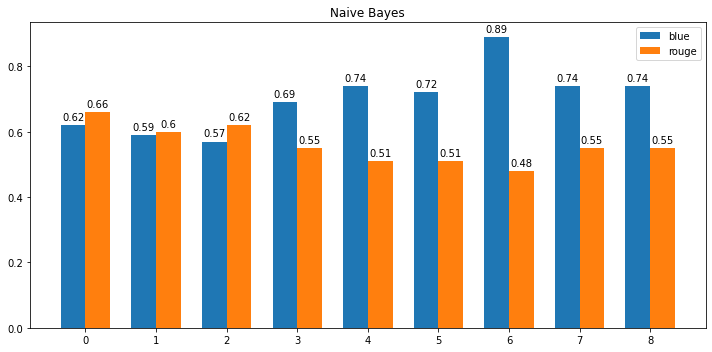

Legend:
0 NB pentru unigrame
1 NB pentru unigrame, fara stop words
2 NB pentru unigrame, fara stop words, cu lematizare
3 NB pentru bigrame
4 NB pentru bigrame, fara stop words
5 NB pentru bigrame, fara stop words, cu lematizare
6 NB pentru 4grame
7 NB pentru 4grame, fara stop words
8 NB pentru 4grame, fara stop words, cu lematizare


In [253]:
plot_bars("Naive Bayes", results[:9])
print("Legend:")
for i, r in enumerate(results[:9]):
    print(i, r.model)

#### Observatii

**Unigrame:**
- E o varianta echilibrata, cu ambele valori (blue si rouge) in jurul lui 0.6. Asta inseamna (aproximativ) ca pastreaza 60% din propozitiile care aparea si in "ground truth", dar 40% din propozitii/tokeni sunt "in plus".
- Desi nu se modifica semnificativ, observam ca prin eliminarea stop words, atat blue, cat si rouge, scad. Asta ar putea fi pentru ca , cuvintele stop alese nu sunt corecte si au o semnificatie in textele respective. Textele reprezinta niste stiri, menite publicului larg, si includ multe cuvinte simple si usor de inteles, pe care poate spacy le-a considerat nesemnificative, dar ele influentau usor performantele.
- Prin lematizare, creste usor valoarea recall (rouge) deci sunt pastrate in rezumat mai multe propozitii relevante, dar blue scade usor.

**Bigrame:**
- Au o precizie mai mare decat varianta cu unigrame, dar un recall mai mic. Insemna ca pastreaza mai putine propozitii, dar acestea se regasesc in cele corecte cu un procent mai bun (~70%).
- Prin eliminarea stop words, blue creste cu 5 procente, pentru ca bigramele formate sunt mai relevante.
- Prin lematizare, precizia scade usor. Poate forma specifica a unor cuvinte era relevanta.

**4-grame:**
- Are cea mai buna precizie (aproape 90%). Tokenii formati din 4 cuvinte sunt mult mai specifici si clasifica mai corect propozitiile in relevante/nerelevante. Recall este in acelasi range de valori ca pentru unigrame si bigrame, iar valoarea de 0.5 poate insemna ca ar fi nevoie de mai multe propozitii incluse in rezumat.
- Eliminarea stop words duce la o precizie cu 15 procente mai mica pentru ca exista multe propozitii scurte, care prin eliminarea aceasta, devin si mai mici si uneori nu au nici 4 cuvinte pentru formarea unei 4-grame, deci nu reusesc sa influenteze corect parametrii modelului.

### Diferentele de performanta aduse de fiecare modificare a algoritmului TF-IDF

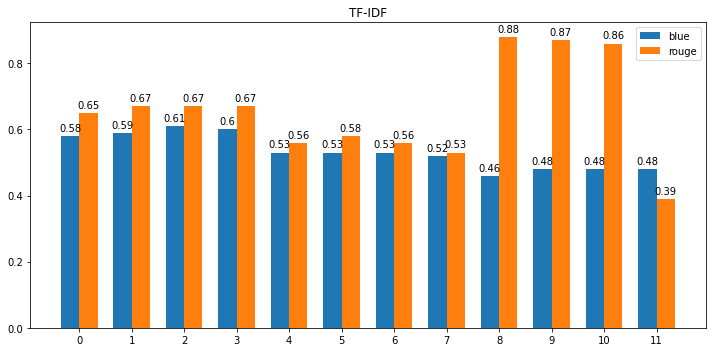

Legend:
0 TF-IDF pentru unigrame
1 TF-IDF pentru unigrame, doar substantive
2 TF-IDF pentru unigrame, doar substantive, similaritate cu titlu
3 TF-IDF pentru unigrame, doar substantive, similaritate cu titlu, pozitia in text
4 TF-IDF pentru bigrame
5 TF-IDF pentru bigrame, doar substantive
6 TF-IDF pentru bigrame, doar substantive, similaritate cu titlu
7 TF-IDF pentru bigrame, doar substantive, similaritate cu titlu, pozitia in text
8 TF-IDF pentru 4-grame
9 TF-IDF pentru 4-grame, doar substantive
10 TF-IDF pentru 4-grame, doar substantive, similaritate cu titlu
11 TF-IDF pentru 4-grame, doar substantive, similaritate cu titlu, pozitia in text


In [265]:
plot_bars("TF-IDF", results[9:(9+12)])
print("Legend:")
for i, r in enumerate(results[9:(9+12)]):
    print(i, r.model)

#### Observatii
- Se observa in general o precizie scazuta (multe variante cu <0.5), dar un recall foarte mare pentru jumatate din variante. Acest lucru se datoreaza faptului ca acest model impune includerea a unui numar strict de propozitii (30% din nr. de propozitii din textul original) chiar daca unele poate au un scor prea mic ca sa fie relevante.
- Valorile pentru variantele cu acelasi n in n-grame sunt asemanatoare, folosirea doar a substantivelor si ponderarea similitudinii cu titlu aducand o usoara crestere pentru blue si rouge. Singura tehnica , care schimba mult performantele, pentru 4-grame, este folosirea pozitiei in text. Este din cauza ca, multe propozitii sunt scurte si asa ca uneori nici nu returneaza nicio 4-grama, iar potrivirea a 4 cuvinte consecutive cu titlul e putin probabile, asa ca singura metrica care influenteaza mult scorul unei propozitii este pozitia in text. Dar aceasta singura nu e suficient pentru a clasifica corect propozitia. 

### Comparatie algoritmilor
Am ales de la fiecare algoritm 2 variante care au dat rezultate bune pentru a putea compara modelele.

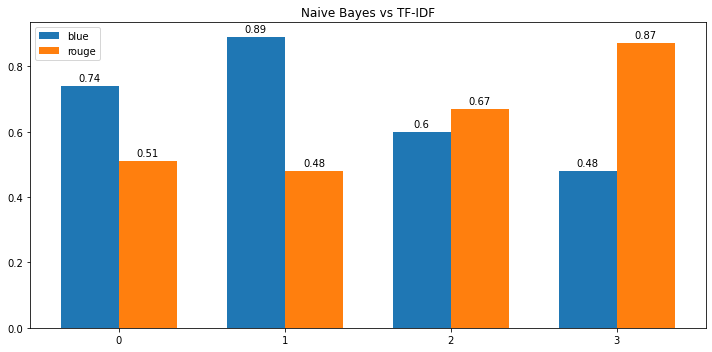

Legend:
4 NB pentru bigrame, fara stop words
6 NB pentru 4grame
12 TF-IDF pentru unigrame, doar substantive, similaritate cu titlu, pozitia in text
18 TF-IDF pentru 4-grame, doar substantive


In [256]:
plot_bars("Naive Bayes vs TF-IDF", [results[4], results[6], results[9+3], results[9+9]])
print("Legend:")
for i in [4, 6, 9+3, 9+9]:
    print(i, results[i].model)

#### Observatii

- Algoritmul Naive Bayes are o precizie mai buna (chiar foarte buna - 89%) fata de algoritmul bazat pe scorul TF-IDF, dar un recall mai scazut (0.51 vs 0.87).
- Precizia (valoarea blue) are valori mai mici atunci cand sumarizarea calculata include mai multe propozitii care nu faceau parte din "ground truth". In cazul TF-IDF, sunt pastrate mereu 30% din propozitii din stire, in timp ce Naive Bayes nu are un numar de propozitii tinta, ci le include doar pe cele pe care le considera relevante. O posibila imbunatatire pentru TF-IDF extrasa din aceasta idee ar fi setarea unui scor minim necesar sau micsorarea valorii k. Dar daca k scade, scade si recall.
- Recall (valoarea rouge) creste atunci cand in sumarizare apar mai multe propozitii pentru ca nu depinde de cat de multe sunt gresit incluse, ci doar de cat de multe sunt comune cu "ground truth". De accea la TF-IDF, cand includem 30% din propozitii, sunt mai multe decat la Naive Bayes si are un recall mai bun.

#### Imbunatatire TF-IDF prin adaugarea unui scor minim necesar includerii propozitiei
Observam mai jos ca precizia creste (cu 0.04), dar recall incepe sa scada, asa cum ne-am astepta atunci cand includem mai putine propozitii. Poate cu alte valori pentru scorul minim, se poate obtine o precizie si mai buna.

Result(model='TF-IDF cu folosirea unui scor minim', blue=0.64, rouge=0.51)


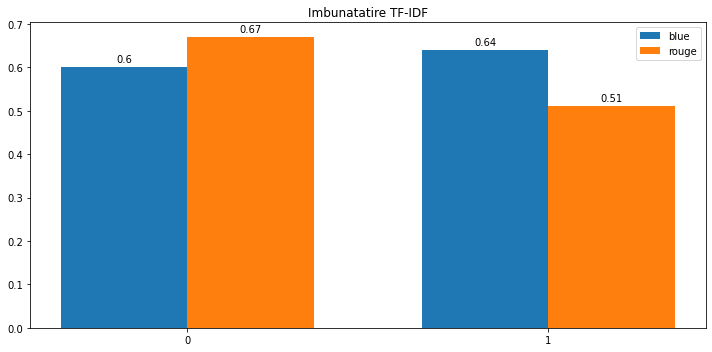

In [263]:
bonus_results = Result("TF-IDF cu folosirea unui scor minim",
                      *train_and_evaluate_tfidf(1, True, True, True))
print(bonus_results)
plot_bars("Imbunatatire TF-IDF", [results[9+3], bonus_results])

### Analiza celor mai bune variante ale modelelor pe fiecare categorie de stiri

In [278]:
def train_and_evaluate_bayes_category(idx, ngrams, elim_stop, lemma):
    training_results = [None] * len(CATEGORIES)
    training_results[idx] = count_words(news_train[idx], summaries_train[idx], ngrams, elim_stop, lemma)
    
    return evaluate(training_results, summarize_bayes, ngrams, elim_stop, lemma, [idx])

def train_and_evaluate_tfidf_category(idx, ngrams, only_subst, use_title, weight_position):
    training_results = [None] * len(CATEGORIES)
    training_results[idx] = compute_scores(news_train[idx], ngrams, only_subst)
    
    return evaluate_tfidf(training_results, summarize_tfidf, ngrams, only_subst, use_title, weight_position, [idx])

In [273]:
categories_results = []
for idx in range(len(CATEGORIES)):
    categories_results.append(Result("Bayes " + CATEGORIES[idx], *train_and_evaluate_bayes_category(idx, 2, True, False)))

In [281]:
for idx in range(len(CATEGORIES)):
    categories_results.append(Result("TF-IDF " + CATEGORIES[idx], *train_and_evaluate_tfidf_category(idx, 1, True, True, True)))

In [282]:
for r in categories_results:
    print(r)

Result(model='Bayes business', blue=0.71, rouge=0.45)
Result(model='Bayes entertainment', blue=0.76, rouge=0.52)
Result(model='Bayes politics', blue=0.75, rouge=0.5)
Result(model='Bayes sport', blue=0.67, rouge=0.5)
Result(model='Bayes tech', blue=0.83, rouge=0.57)
Result(model='TF-IDF business', blue=0.61, rouge=0.5)
Result(model='TF-IDF entertainment', blue=0.66, rouge=0.56)
Result(model='TF-IDF politics', blue=0.64, rouge=0.56)
Result(model='TF-IDF sport', blue=0.61, rouge=0.57)
Result(model='TF-IDF tech', blue=0.64, rouge=0.56)


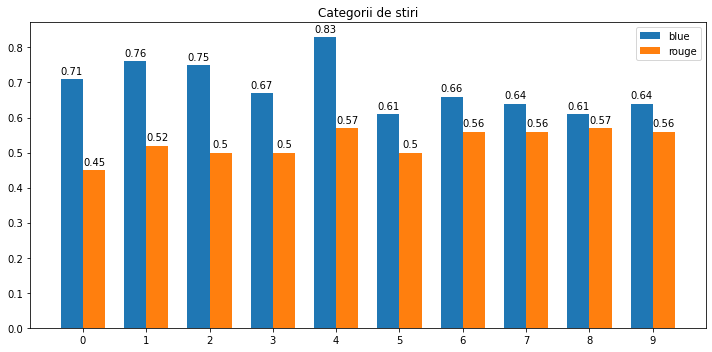

Legend:
0 Bayes business
1 Bayes entertainment
2 Bayes politics
3 Bayes sport
4 Bayes tech
5 TF-IDF business
6 TF-IDF entertainment
7 TF-IDF politics
8 TF-IDF sport
9 TF-IDF tech


In [283]:
plot_bars("Categorii de stiri", categories_results)
print("Legend:")
for i, r in enumerate(categories_results):
    print(i, r.model)

#### Observatii
- Categories business are recall cel mai mic pentru ambii algoritmi: mai putin de jumatate din tokenii din "ground truth" se regasesc in sumarizarile calculate.
- Pentru algoritmul TF-IDF, recall este cu peste 10 procente mai mic decat daca antrenam modelul cu toate categoriile, iar precizia este asemenatoare cu cea overall. Inseamna ca facand vocabularul mai specific impingem modelul sa aleaga mai putine propozitii care se regaseau in "ground truth".
- Pentru algoritmul Bayes, categoria tech are o precizie mult mai buna, probabil datorata multitudinii de cuvinte specializate ce intra in bigrame foarte relevante.

## Analiza calitativa pe cateva exemple (din categoria politics)

In [285]:
training_bayes_1 = [None] * len(CATEGORIES)
training_bayes_1[POLITICS] = count_words(news_train[POLITICS], summaries_train[POLITICS], 2, False, False)

training_bayes_2 = [None] * len(CATEGORIES)
training_bayes_2[POLITICS] = count_words(news_train[POLITICS], summaries_train[POLITICS], 2, True, False)

training_bayes_3 = [None] * len(CATEGORIES)
training_bayes_3[POLITICS] = count_words(news_train[POLITICS], summaries_train[POLITICS], 2, True, True)

In [286]:
training_tfidf_1 = [None] * len(CATEGORIES)
training_tfidf_1[POLITICS] = compute_scores(news_train[POLITICS], 1, False)

training_tfidf_2 = [None] * len(CATEGORIES)
training_tfidf_2[POLITICS] = compute_scores(news_train[POLITICS], 1, True)

In [290]:
print("Pentru 3 exemple din setul de antrenare")
print("---------------------------------------")

for i in range(0, 3):
    print("Textul original:")
    with zipFile.open(news_train[POLITICS][i]) as f:
        print(f.read())
    print("---------------------------------------")
    
    print("Sumarizarea reala:")
    with zipFile.open(summaries_train[POLITICS][i]) as f:
        print(f.read())
    print("---------------------------------------")
    
    print("Sumarizarea produse de Bayes, cu bigrame:")
    print(summarize_bayes(training_bayes_1[POLITICS], news_train[POLITICS][i], 2, False, False)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de Bayes, cu bigrame, eliminare de stop words:")
    print(summarize_bayes(training_bayes_2[POLITICS], news_train[POLITICS][i], 2, True, False)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de Bayes, cu bigrame, eliminare de stop words, lematizare:")
    print(summarize_bayes(training_bayes_3[POLITICS], news_train[POLITICS][i], 2, True, True)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de TF-IDF, cu unigrame:")
    print(summarize_tfidf(training_tfidf_1[POLITICS], news_train[POLITICS][i], 2, False, False, False)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de TF-IDF, cu unigrame, doar substantive:")
    print(summarize_tfidf(training_tfidf_1[POLITICS], news_train[POLITICS][i], 2, True, False, False)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de TF-IDF, cu unigrame, doar substantive, similaritate cu titlu:")
    print(summarize_tfidf(training_tfidf_1[POLITICS], news_train[POLITICS][i], 2, True, True, False)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de TF-IDF, cu unigrame, doar substantive, similaritate cu title, pozitia in text:")
    print(summarize_tfidf(training_tfidf_1[POLITICS], news_train[POLITICS][i], 2, True, False, False)[0])
    print("---------------------------------------")

Pentru 3 exemple din setul de antrenare
---------------------------------------
Textul original:
b'Concerns at school diploma plan\n\nFinal appeals are being made for the government not to ditch the reform plan for England\'s secondary schools put forward by the Tomlinson report.\n\nThe government\'s response to the plan for a four-tier diploma to replace all existing 14-19 qualifications is expected next week. Some are worried it could be scuppered if, as Tony Blair and Ruth Kelly have suggested, GCSEs and A-levels stay. Sir Mike Tomlinson himself was briefed only this week. He is said to be feeling more comfortable about what the government is likely to say than if he had read only what was in newspapers in the earlier part of the week. But the government was said to be still rewriting its response on Friday. "It will be a tragedy if the government comes through with a half-hearted response," said the chairman of the Commons education select committee, Labour MP Barry Sheerman.\n\nHi

- Se observa ideea ce a mai fost exprimata anterioara, cand comparam valorile recall pentru cei 2 algoritmi: TF-IDF pastreaza mai multe propozitii decat Bayes pentru ca are un numar strict de propozitii ce trebuie pastrate, chiar daca relevante lor scade foarte mult.
- TF-IDF pastreaza titlul. O posibila imbunatatire ar fi sa oprim acest lucru. Asta poate fi si un indicator ca ponderea pentru titlu este prea mare.
- Sumarizarile obtinute de cele 2 modele sunt diferite, dar variantele din cadrul unui model au obtinut aceleasi rezumate.

In [291]:
print("Pentru 3 exemple din setul de test")
print("---------------------------------------")

for i in range(0, 3):
    print("Textul original:")
    with zipFile.open(news_test[POLITICS][i]) as f:
        print(f.read())
    print("---------------------------------------")
    
    print("Sumarizarea reala:")
    with zipFile.open(summaries_test[POLITICS][i]) as f:
        print(f.read())
    print("---------------------------------------")
    
    print("Sumarizarea produse de Bayes, cu bigrame:")
    print(summarize_bayes(training_bayes_1[POLITICS], news_test[POLITICS][i], 2, False, False)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de Bayes, cu bigrame, eliminare de stop words:")
    print(summarize_bayes(training_bayes_2[POLITICS], news_test[POLITICS][i], 2, True, False)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de Bayes, cu bigrame, eliminare de stop words, lematizare:")
    print(summarize_bayes(training_bayes_3[POLITICS], news_test[POLITICS][i], 2, True, True)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de TF-IDF, cu unigrame:")
    print(summarize_tfidf(training_tfidf_1[POLITICS], news_test[POLITICS][i], 2, False, False, False)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de TF-IDF, cu unigrame, doar substantive:")
    print(summarize_tfidf(training_tfidf_1[POLITICS], news_test[POLITICS][i], 2, True, False, False)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de TF-IDF, cu unigrame, doar substantive, similaritate cu titlu:")
    print(summarize_tfidf(training_tfidf_1[POLITICS], news_test[POLITICS][i], 2, True, True, False)[0])
    print("---------------------------------------")
    
    print("Sumarizarea produse de TF-IDF, cu unigrame, doar substantive, similaritate cu title, pozitia in text:")
    print(summarize_tfidf(training_tfidf_1[POLITICS], news_test[POLITICS][i], 2, True, False, False)[0])
    print("---------------------------------------")

Pentru 3 exemple din setul de test
---------------------------------------
Textul original:
b'Brown in appeal for Labour unity\n\nGordon Brown has made an appeal for unity after reports claimed Mr Blair went back on a pledge to stand down before the next general election.\n\nThe chancellor would not comment on the reports, but insisted he would not be "diverted or distracted" from tackling the challenges faced by the country. His only "motivation" was to ensure Labour was re-elected, he insisted. Mr Blair earlier dismissed the claim he had reneged on a promise to stand aside for Gordon Brown as old news. According to a new book, Brown\'s Britain by Sunday Telegraph journalist Robert Peston, Mr Blair went back on a pledge to make way for Mr Brown after Cabinet allies intervened in June 2004.\n\nIn an interview with BBC One\'s Breakfast with Frost, Mr Blair said: "I\'ve dealt with this six months ago. I said then you don\'t do deals over jobs like this - you don\'t. "What both of us are 

- Pentru primul exemplu eliminarea de stop words si lematizarea duce la o sumarizare mai scurta si mai buna.
- Numarul de propozitii pentru TF-IDF e prea mare.

## Imbunatatire TF-IDF - k mai mic si eliminarea titlului

Result(model='TF-IDF cu folosirea unui scor minim', blue=0.65, rouge=0.43)


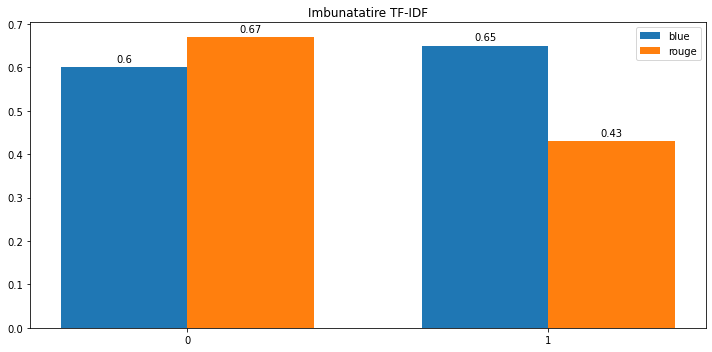

In [296]:
bonus_results = Result("TF-IDF cu folosirea unui scor minim",
                      *train_and_evaluate_tfidf(1, True, True, True))
print(bonus_results)
plot_bars("Imbunatatire TF-IDF", [results[9+3], bonus_results])

- Recall mai mic (ne asteptam pt. ca am scazut nr. de propozitii).
- Precizie un pic crescuta.